In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

/home/yungshun/.virtualenvs/yungshun-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yungshun/.virtualenvs/yungshun-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yungshun/.virtualenvs/yungshun-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yungshun/.virtualenvs/yungshun-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yungshun/.virtualenvs/yungshun-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. E

# Sales Transactions Dataset Weekly

In [2]:
sales = pd.read_csv('/home/yungshun/workspace/py3/sklearn-time-series-forcasting-lgbm-regressor/datasets/sales_transactions_dataset_weekly.csv')
sales.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


In [3]:
sales = sales.filter(regex=r'Product|W')
sales.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


### melt()

<code>pandas.melt(frame, id_vars=None, value_vars=None, var_name=None, value_name='value', col_level=None)</code> - unpivot a DataFrame from wide format to long format, optionally leaving identifier variables set (id_vars), while all other columns, considered measured variables (value_vars), are unpivoted to the row axis, leaving just two non-identifier columns, 'variable' and 'value'.

In [4]:
melt = sales.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')
melt.head()

,Product_Code,Week,Sales
0,P1,W0,11
1,P2,W0,7
2,P3,W0,7
3,P4,W0,12
4,P5,W0,8


In [5]:
melt['Product_Code'] = melt['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['Week', 'Product_Code'])
melt.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


## Feature engineering

We need to have variables to send to our model and get the predictions. For now, besides the product code and the week, we will create two features that usually help a lot with time series: <b>lags</b> and <b>differences</b>.

Last Week Sales: this is simply the amount of sales that a product had in the previous week.<br/>
Last Week Diff: the difference between the amount of sales in the previous week and the week before it (t-1 - t-2).

In [6]:
melt2 = melt.copy()

### shift()

<code>DataFrame.shift(periods=1, freq=None, axis=0)</code> - shift index by desired number of periods with an optional time freq.

In [7]:
melt2['Last_Week_Sales'] = melt2.groupby(['Product_Code'])['Sales'].shift()
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales
0,1,0,11,NaN
1,2,0,7,NaN
2,3,0,7,NaN
3,4,0,12,NaN
4,5,0,8,NaN


### diff()

<code>DataFrame.diff(periods=1, axis=0)</code> - first discrete difference of element.

In [8]:
melt2['Last_Week_Diff'] = melt2.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
0,1,0,11,NaN,NaN
1,2,0,7,NaN,NaN
2,3,0,7,NaN,NaN
3,4,0,12,NaN,NaN
4,5,0,8,NaN,NaN


In [9]:
melt2 = melt2.dropna()
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0


## Evaluation metrics

In [10]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

## Baseline & validation split

Let's say that in real life your model will run every Sunday night, so that early on Monday the managers can make decisions based on the predictions for the next week. 

To see if our model will work in this scenario, weeks it has not seen before, we will use a <b>sliding window validation</b>. This means that we are going to simulate training the model in all the weeks up to the one we want to predict, and evaluate our score in the new week.

And, to avoid having a very good model in a small amount of weeks simply due to luck, we will use every week from 40 to 52, repeating the process for one at a time, and compute the score.

As this is only a demonstration of the method, to keep it simple we are not separating a test set. In your projects, always keep some periods out of your validation to evaluate your model when you finish developing it. This is very important, and helps you be more secure about your model performing well when deployed.

To make sure the model is worth using we have to set a <b>baseline score</b> that it has to beat. In this case, a reasonably strong baseline is using the last week amount of sales as a prediction for the sales this week.

In [11]:
mean_error = []
for week in range(40,52):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    p = val['Last_Week_Sales'].values
    
    error = rmsle(val['Sales'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.51952
Week 41 - Error 0.51691
Week 42 - Error 0.51026
Week 43 - Error 0.50792
Week 44 - Error 0.53409
Week 45 - Error 0.52347
Week 46 - Error 0.50018
Week 47 - Error 0.49138
Week 48 - Error 0.50585
Week 49 - Error 0.50547
Week 50 - Error 0.52220
Week 51 - Error 0.55242
Mean Error = 0.51581


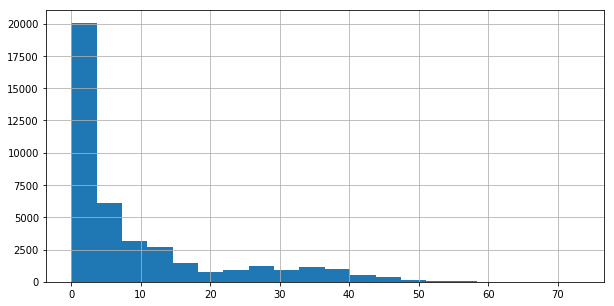

In [12]:
melt2['Sales'].hist(bins=20, figsize=(10,5))

## Training

As a first model, let's train a <b>Random Forest</b>. Besides being a strong model with structured data (like the one we have), we usually can already get a very good result by just setting a high number of trees.

We will keep the Week as a feature although our model will have never seen the new week value. It may be that after week 35, for example, we have more sales for a product. This type of effect can be captured by the model.

As decision trees can handle categorical features well even in <b>ordinal encoding</b>, we left them in this format. Anyway, be careful with these types of features.

In [13]:
mean_error = []
for week in range(40,52):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.46242
Week 41 - Error 0.45964
Week 42 - Error 0.46166
Week 43 - Error 0.46655
Week 44 - Error 0.47122
Week 45 - Error 0.43100
Week 46 - Error 0.47183
Week 47 - Error 0.44945
Week 48 - Error 0.46080
Week 49 - Error 0.44696
Week 50 - Error 0.47465
Week 51 - Error 0.48651
Mean Error = 0.46189


In [14]:
# Add some features from more weeks in the past. First, let's add the lag and the difference of sales for the week
# before the previous.
melt3 = melt.copy()
melt3['Last_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift()
melt3['Last_Week_Diff'] = melt3.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt3['Last-1_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift(2)
melt3['Last-1_Week_Diff'] = melt3.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt3 = melt3.dropna()
melt3.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff
2433,1,3,8,10.0,-2.0,12.0,1.0
2434,2,3,2,3.0,-3.0,6.0,-1.0
2435,3,3,9,8.0,-3.0,11.0,4.0
2436,4,3,5,13.0,5.0,8.0,-4.0
2437,5,3,11,13.0,8.0,5.0,-3.0


In [15]:
mean_error = []
for week in range(40,52):
    train = melt3[melt3['Week'] < week]
    val = melt3[melt3['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.44389
Week 41 - Error 0.45812
Week 42 - Error 0.43652
Week 43 - Error 0.44033
Week 44 - Error 0.46318
Week 45 - Error 0.42361
Week 46 - Error 0.45752
Week 47 - Error 0.44533
Week 48 - Error 0.44598
Week 49 - Error 0.43538
Week 50 - Error 0.47349
Week 51 - Error 0.46487
Mean Error = 0.44902


In [16]:
melt4 = melt.copy()
melt4['Last_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift()
melt4['Last_Week_Diff'] = melt4.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt4['Last-1_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(2)
melt4['Last-1_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt4['Last-2_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(3)
melt4['Last-2_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-2_Week_Sales'].diff()
melt4 = melt4.dropna()
melt4.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
3244,1,4,13,8.0,-2.0,10.0,-2.0,12.0,1.0
3245,2,4,7,2.0,-1.0,3.0,-3.0,6.0,-1.0
3246,3,4,10,9.0,1.0,8.0,-3.0,11.0,4.0
3247,4,4,9,5.0,-8.0,13.0,5.0,8.0,-4.0
3248,5,4,6,11.0,-2.0,13.0,8.0,5.0,-3.0


In [17]:
mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.43096
Week 41 - Error 0.43894
Week 42 - Error 0.42754
Week 43 - Error 0.41965
Week 44 - Error 0.44807
Week 45 - Error 0.40729
Week 46 - Error 0.43950
Week 47 - Error 0.43334
Week 48 - Error 0.43856
Week 49 - Error 0.43049
Week 50 - Error 0.45920
Week 51 - Error 0.45356
Mean Error = 0.43559
